In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout
from sklearn.feature_selection import VarianceThreshold


sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

--- Primeiras 5 linhas do dataset ---
         obj_ID       alpha      delta         u         g         r  \
0  1.237661e+18  135.689107  32.494632  23.87882  22.27530  20.39501   
1  1.237665e+18  144.826101  31.274185  24.77759  22.83188  22.58444   
2  1.237661e+18  142.188790  35.582444  25.26307  22.66389  20.60976   
3  1.237663e+18  338.741038  -0.402828  22.13682  23.77656  21.61162   
4  1.237680e+18  345.282593  21.183866  19.43718  17.58028  16.49747   

          i         z  run_ID  rerun_ID  cam_col  field_ID   spec_obj_ID  \
0  19.16573  18.79371    3606       301        2        79  6.543777e+18   
1  21.16812  21.61427    4518       301        5       119  1.176014e+19   
2  19.34857  18.94827    3606       301        2       120  5.152200e+18   
3  20.50454  19.25010    4192       301        3       214  1.030107e+19   
4  15.97711  15.54461    8102       301        3       137  6.891865e+18   

    class  redshift  plate    MJD  fiber_ID  
0  GALAXY  0.634794   5812

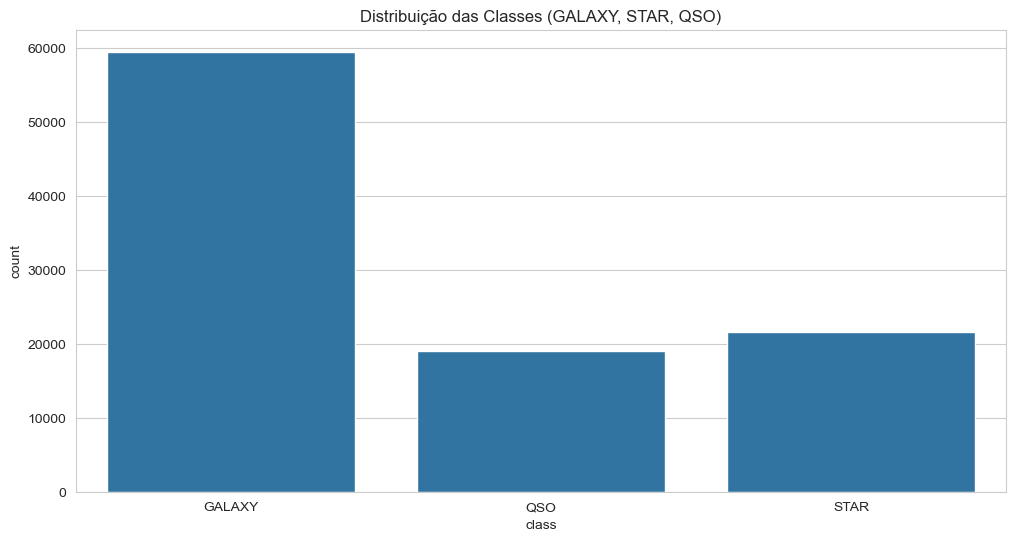

In [2]:
df = pd.read_csv('../data/star_classification.csv')


print("--- Primeiras 5 linhas do dataset ---")
print(df.head())
print("\n--- Informações do Dataset ---")
df.info()

print("\n--- Distribuição das Classes ---")
print(df['class'].value_counts())
sns.countplot(x='class', data=df)
plt.title('Distribuição das Classes (GALAXY, STAR, QSO)')
plt.show()

In [3]:
le = LabelEncoder()
df['class_encoded'] = le.fit_transform(df['class'])
class_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(f"Mapeamento de Classes: {class_mapping}")
df_processed = df.drop(['class', 'obj_ID'], axis=1)

print("\n--- Dataset após codificação e remoção de colunas desnecessárias ---")
print(df_processed.head())

Mapeamento de Classes: {'GALAXY': 0, 'QSO': 1, 'STAR': 2}

--- Dataset após codificação e remoção de colunas desnecessárias ---
        alpha      delta         u         g         r         i         z  \
0  135.689107  32.494632  23.87882  22.27530  20.39501  19.16573  18.79371   
1  144.826101  31.274185  24.77759  22.83188  22.58444  21.16812  21.61427   
2  142.188790  35.582444  25.26307  22.66389  20.60976  19.34857  18.94827   
3  338.741038  -0.402828  22.13682  23.77656  21.61162  20.50454  19.25010   
4  345.282593  21.183866  19.43718  17.58028  16.49747  15.97711  15.54461   

   run_ID  rerun_ID  cam_col  field_ID   spec_obj_ID  redshift  plate    MJD  \
0    3606       301        2        79  6.543777e+18  0.634794   5812  56354   
1    4518       301        5       119  1.176014e+19  0.779136  10445  58158   
2    3606       301        2       120  5.152200e+18  0.644195   4576  55592   
3    4192       301        3       214  1.030107e+19  0.932346   9149  58039   
4  

In [4]:
features = df_processed.drop('class_encoded', axis=1)
print(f"Dataset original com {df_processed.shape[0]} linhas.")

Q1 = features.quantile(0.25)
Q3 = features.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_mask = ((features < lower_bound) | (features > upper_bound)).any(axis=1)

df_no_outliers = df_processed[~outlier_mask]

print(f"Dataset após remoção de outliers com {df_no_outliers.shape[0]} linhas.")
print(f"Foram removidas {df_processed.shape[0] - df_no_outliers.shape[0]} linhas contendo outliers.")

Dataset original com 100000 linhas.
Dataset após remoção de outliers com 85595 linhas.
Foram removidas 14405 linhas contendo outliers.


In [5]:
X = df_no_outliers.drop('class_encoded', axis=1)
y = df_no_outliers['class_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Formato de X_train: {X_train.shape}")
print(f"Formato de X_test: {X_test.shape}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Formato de X_train: (68476, 16)
Formato de X_test: (17119, 16)


In [6]:
remover_constantes = VarianceThreshold(threshold=0.0)

X_train_scaled_var = remover_constantes.fit_transform(X_train_scaled)

X_test_scaled_var = remover_constantes.transform(X_test_scaled)

removed_features_mask = ~remover_constantes.get_support()
removed_features_names = X.columns[removed_features_mask]

print(f"Shape original do treino: {X_train_scaled.shape}")
print(f"Shape do treino após remover constantes: {X_train_scaled_var.shape}")
if len(removed_features_names) > 0:
    print(f"Feature constante removida: {list(removed_features_names)}")

k_best = 10
selector = SelectKBest(score_func=f_classif, k=k_best)

X_train_selected = selector.fit_transform(X_train_scaled_var, y_train)

X_test_selected = selector.transform(X_test_scaled_var)

print(f"\nFormato dos dados de treino após seleção: {X_train_selected.shape}")
print(f"Formato dos dados de teste após seleção: {X_test_selected.shape}")

Shape original do treino: (68476, 16)
Shape do treino após remover constantes: (68476, 15)
Feature constante removida: ['rerun_ID']

Formato dos dados de treino após seleção: (68476, 10)
Formato dos dados de teste após seleção: (17119, 10)


In [7]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

print("--- Treinando o modelo Random Forest ---")
rf_model.fit(X_train_selected, y_train)
print("Treinamento concluído.")

--- Treinando o modelo Random Forest ---
Treinamento concluído.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,859 (38.51 KB)

 Trainable params: 9,859 (38.51 KB)

 Non-trainable params: 0 (0.00 B)


--- Treinando o modelo MLP ---
Epoch 1/50


2025-06-22 22:19:13.910093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1712/1712 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.7648 - loss: 0.8443 - val_accuracy: 0.9168 - val_loss: 0.2604
Epoch 2/50
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.8681 - loss: 0.3709 - val_accuracy: 0.9337 - val_loss: 0.2509
Epoch 3/50
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.8783 - loss: 0.3469 - val_accuracy: 0.9200 - val_loss: 0.2501
Epoch 4/50
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.8804 - loss: 0.3444 - val_accuracy: 0.8922 - val_loss: 0.2807
Epoch 5/50
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.8850 - loss: 0.3531 - val_accuracy: 0.9075 - val_loss: 0.2669
Epoch 6/50
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.8721 - loss: 0.4041 - val_accuracy: 0.9105 - val_loss: 0.3142
Epoch 7/50
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.8655 - loss: 0.4768 - val_accuracy: 0.8872 - val_loss: 0.3698
Epoch 8/50
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.8620 - loss: 0.51

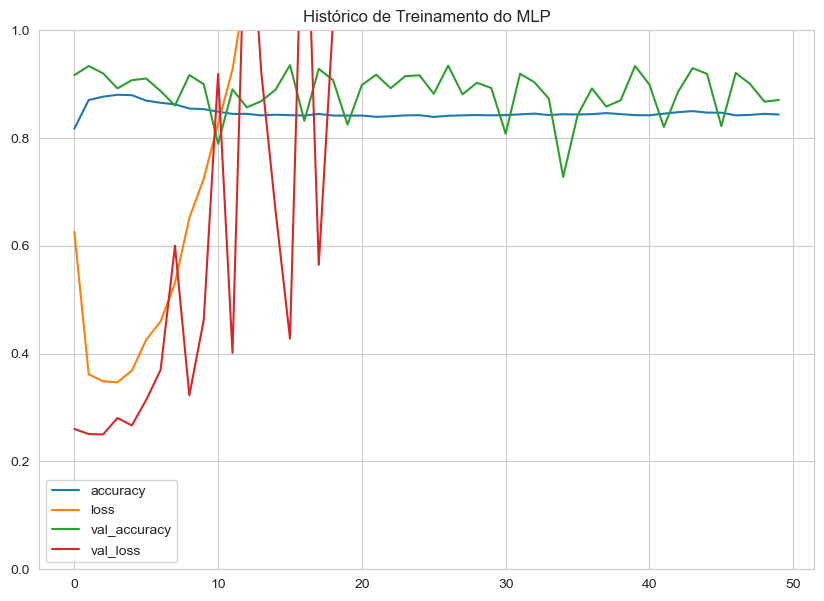

In [9]:
mlp_model = Sequential([
    InputLayer(shape=(X_train_selected.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

mlp_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

mlp_model.summary()

print("\n--- Treinando o modelo MLP ---")
history = mlp_model.fit(
    X_train_selected,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)
print("Treinamento concluído.")

pd.DataFrame(history.history).plot(figsize=(10, 7))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.title('Histórico de Treinamento do MLP')
plt.show()

In [12]:
history = mlp_model.fit(
    X_train_selected,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)
print("Treinamento concluído.")

Epoch 1/50
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.8420 - loss: 11.8783 - val_accuracy: 0.9209 - val_loss: 4.9065
Epoch 2/50
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 184s 107ms/step - accuracy: 0.8402 - loss: 11.4726 - val_accuracy: 0.8843 - val_loss: 6.1596
Epoch 3/50
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 243s 142ms/step - accuracy: 0.8420 - loss: 12.9857 - val_accuracy: 0.8865 - val_loss: 8.6863
Epoch 4/50
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.8422 - loss: 12.4884 - val_accuracy: 0.8711 - val_loss: 8.8630
Epoch 5/50
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.8456 - loss: 11.0811 - val_accuracy: 0.8613 - val_loss: 7.4672
Epoch 6/50
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.8460 - loss: 12.9991 - val_accuracy: 0.9301 - val_loss: 7.1559
Epoch 7/50
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.8455 - loss: 13.1064 - val_accuracy: 0.9015 - val_loss: 8.0637
Epoch 8/50
1712/1712 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accurac

--- Resultados da Avaliação do Random Forest ---
Acurácia: 0.9790

Relatório de Classificação:
              precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.98     11118
         QSO       0.94      0.88      0.91      1918
        STAR       0.99      1.00      1.00      4083

    accuracy                           0.98     17119
   macro avg       0.97      0.96      0.96     17119
weighted avg       0.98      0.98      0.98     17119



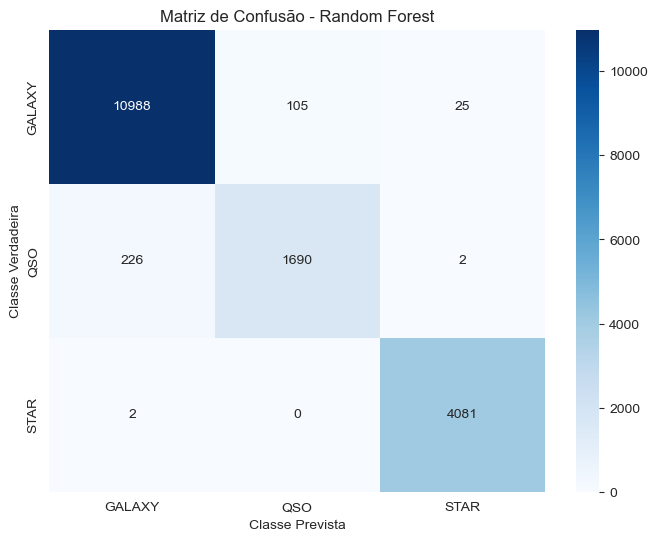

In [13]:
y_pred_rf = rf_model.predict(X_test_selected)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf, target_names=le.classes_)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

print("--- Resultados da Avaliação do Random Forest ---")
print(f"Acurácia: {accuracy_rf:.4f}")
print("\nRelatório de Classificação:")
print(report_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matriz de Confusão - Random Forest')
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Verdadeira')
plt.show()

535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
--- Resultados da Avaliação do MLP ---
Acurácia: 0.9356

Relatório de Classificação:
              precision    recall  f1-score   support

      GALAXY       0.96      0.96      0.96     11118
         QSO       0.83      0.78      0.80      1918
        STAR       0.92      0.95      0.94      4083

    accuracy                           0.94     17119
   macro avg       0.90      0.90      0.90     17119
weighted avg       0.94      0.94      0.94     17119



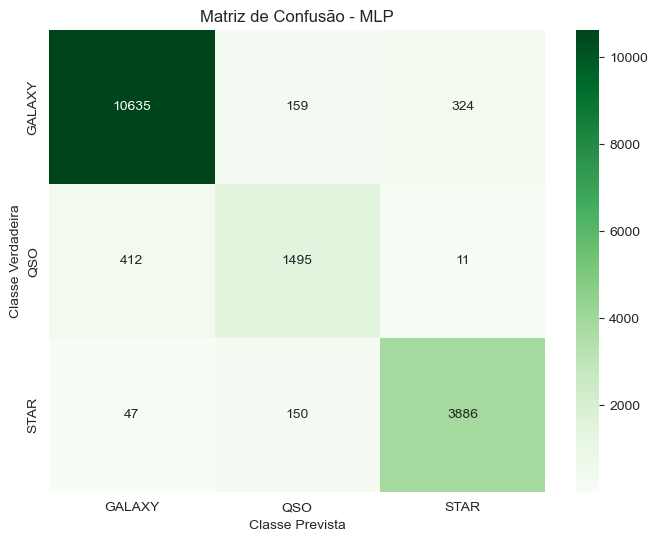

In [14]:
y_prob_mlp = mlp_model.predict(X_test_selected)
y_pred_mlp = np.argmax(y_prob_mlp, axis=1)

accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
report_mlp = classification_report(y_test, y_pred_mlp, target_names=le.classes_)
conf_matrix_mlp = confusion_matrix(y_test, y_pred_mlp)

print("--- Resultados da Avaliação do MLP ---")
print(f"Acurácia: {accuracy_mlp:.4f}")
print("\nRelatório de Classificação:")
print(report_mlp)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_mlp, annot=True, fmt='d', cmap='Greens', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matriz de Confusão - MLP')
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Verdadeira')
plt.show()